In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
sys.path.append('../../')
import Constants as c
import Utilities as utils
from Scaler import Scaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pydotplus
import locale
sns.set_style("darkgrid")

In [3]:
regressors = {
  "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0, max_depth=10, min_samples_split=10, max_features="sqrt"),
  "RandomForestRegressor": RandomForestRegressor(random_state=0, max_depth=10, min_samples_split=10, max_features="sqrt", n_estimators=10),
  "LinearRegression": LinearRegression(),
  "RidgeCV": RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
}

transformers = {
  "RobustScaler": RobustScaler(),
  "StandardScaler": StandardScaler(),
  "MinMaxScaler": MinMaxScaler(),
  "QuantileTransformer": QuantileTransformer(),
  "FunctionTransformer": FunctionTransformer(np.log1p)
}

regressor = regressors["DecisionTreeRegressor"]
transformer = transformers["QuantileTransformer"]
# df = utils.remove_outlier(df, c.LINE)
# df = utils.remove_outlier(df, c.MODULE)


In [4]:
directoryPath = "../../exports"
project_name = "ansible"
task = "BUG"
file = "{0}/{1}/{2}_dataset_{3}.csv"

df = pd.read_csv(file.format(directoryPath, project_name, project_name, task))
# df = utils.isRegularVersion(df)

In [5]:
df[c.DATE] = pd.to_datetime(df[c.DATE])
df[c.NT] = df[[c.NT_CC]].sum(axis=1)
df[c.NO] = df[[c.NO_CC]].sum(axis=1)
df[c.LINE] = df[[c.LINE_CC]].sum(axis=1)
df[c.MODULE] = df[[c.MODULE_CC]].sum(axis=1)
df[c.T_CONTRIBUTORS] = df[[c.T_CC]].sum(axis=1)
# df[c.T_LINE_P] = np.log1p(df[c.T_LINE].shift())
# df[c.T_MODULE_P] = np.log1p(df[c.T_MODULE].shift())

df[c.T_MODULE_P] = df[c.T_MODULE].shift()
df[c.T_LINE_P] = df[c.T_LINE].shift()

df[c.DATE_P] = df[c.DATE].shift()
df[c.DATE_P].fillna(df[c.DATE].min(), inplace=True)

df['Day'] = pd.to_datetime(df[c.DATE]).dt.day
df['Month'] = pd.to_datetime(df[c.DATE]).dt.month
df['Year'] = pd.to_datetime(df[c.DATE]).dt.year
df['Quarter'] = pd.to_datetime(df[c.DATE]).dt.quarter

# Cost section
df[c.HOURS_DIFF] = utils.calculate_hours_diff(df)

if df.isna().values.any():
    df.fillna(0, inplace=True)

# X = df[[c.NT, c.NO, c.MODULE, c.T_CONTRIBUTORS, c.T_LINE_P, c.T_MODULE_P, c.HOURS_DIFF, 'Day', 'Month', 'Year', 'Quarter']]
X1 = df[[c.MODULE, c.NT, c.NO, c.T_CONTRIBUTORS, c.T_LINE_P]]
X2 = df[[c.NT, c.NO, c.T_CONTRIBUTORS, c.T_LINE_P, c.T_MODULE_P, c.HOURS_DIFF]]
# df[c.T_CONTRIBUTORS] = df[c.T_CONTRIBUTORS].replace(0, 1)

# average_module = df[c.MODULE].tail(30).mean()
# average_module_contribs = df[c.T_CONTRIBUTORS].median()
# average_module_release = average_module / average_module_contribs


# df[c.AVG_MODULE_CONTRIBS_CC] = df.apply(utils.calculate_contribs, contribs=average_module_release, axis=1)
# df[c.CONTRIB_DIFF_CC] = round(df[c.T_CONTRIBUTORS] - df[c.AVG_MODULE_CONTRIBS_CC], 2)
# df[c.BILLED_HOURS_CC] = round(df[c.HOURS_DIFF_CC] * df[c.AVG_MODULE_CONTRIBS_CC], 2)
# df[c.COST_CC] = round(df[c.BILLED_HOURS_CC] * 100, 2)

In [6]:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X1)
# PCA_line_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
# PCA_line_df = pd.concat([PCA_line_df, df[c.LINE]], axis = 1)
# PCA_line_df.head()

In [7]:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X2)
# PCA_module_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
# PCA_module_df = pd.concat([PCA_module_df, df[c.MODULE]], axis = 1)
# PCA_module_df.head()

In [8]:
# print out a correlation matrix of our data frame
corr = X1.corr()

# display it
display(corr)

,Module,NT,NO,T_Contributors,T_Line_P
Module,1.000000,0.970337,0.772060,0.868425,0.322030
NT,0.970337,1.000000,0.799854,0.883948,0.256289
NO,0.772060,0.799854,1.000000,0.722032,0.179861
T_Contributors,0.868425,0.883948,0.722032,1.000000,0.272220
T_Line_P,0.322030,0.256289,0.179861,0.272220,1.000000


Text(0.5, 1, 'Correlation Plot for Features - ansible Project')

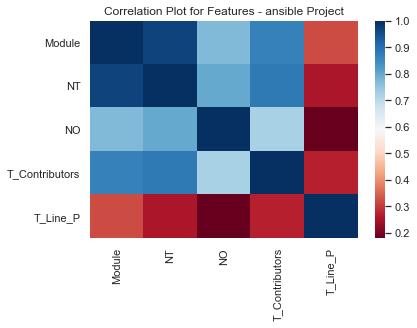

In [9]:
sns.set(style="dark", palette="pastel")
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
ax.set_title('Correlation Plot for Features - {0} Project'.format(project_name))

Text(0.5, 1.0, 'NT vs. Module - ansible')

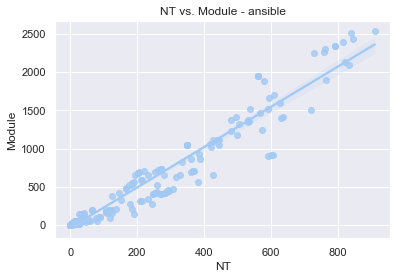

In [10]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y=c.MODULE, data=df)
plt.title('NT vs. Module - {0}'.format(project_name))

Text(0.5, 1.0, 'NO vs. Module - ansible')

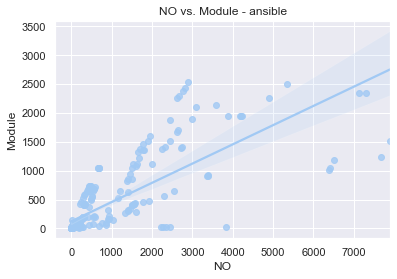

In [11]:
sns.set_style("darkgrid")
module_effort = sns.regplot(x=c.NO, y=c.MODULE, data=df)
plt.title('NO vs. Module - {0}'.format(project_name))

Text(0.5, 1.0, 'T_Contributors vs. Module - ansible')

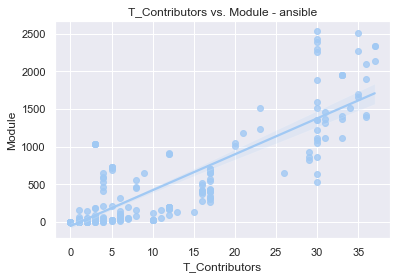

In [12]:
sns.set_style("darkgrid")
contrib_effort = sns.regplot(x=c.T_CONTRIBUTORS, y=c.MODULE, data=df)
plt.title('T_Contributors vs. Module - {0}'.format(project_name))

Text(0.5, 1.0, 'T_Line_P vs. Module - ansible')

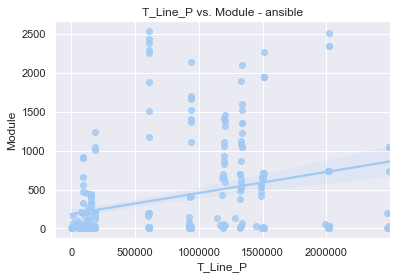

In [13]:
sns.set_style("darkgrid")
sns.regplot(x=c.T_LINE_P, y=c.MODULE, data=df)
plt.title('T_Line_P vs. Module - {0}'.format(project_name))

Text(0.5, 1.0, 'T_Contributors vs. NT - ansible')

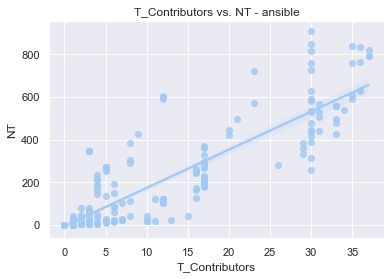

In [14]:
sns.set_style("darkgrid")
contrib_effort = sns.regplot(x=c.T_CONTRIBUTORS, y=c.NT, data=df)
plt.title('T_Contributors vs. NT - {0}'.format(project_name))

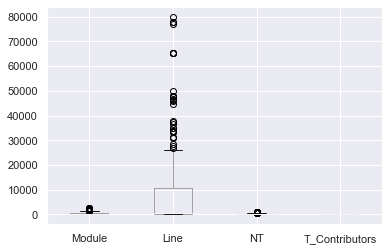

In [15]:
df[[c.MODULE, c.LINE, c.NT, c.T_CONTRIBUTORS]].boxplot()

In [16]:
X = df[[c.NT, c.NO, c.T_LINE_P, c.T_CONTRIBUTORS]]
# X = PCA_line_df[["PC1", "PC2"]]
Y = df[c.LINE]

splits = 10
num_records = len(X)

if num_records <= splits:
    splits = num_records



pipeline = Pipeline(steps=[('scaler', transformer), ('predictor', regressor)])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
# param_grid = {
#     'predictor__max_depth': [5, 10, 15, 20, 25],
#     'predictor__min_samples_split': [5, 10, 15, 20, 25],
# }

# model = GridSearchCV(pipeline, param_grid=param_grid, cv=splits)
# model = TransformedTargetRegressor(regressor=gs, transformer=transformer)
model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
# model=regressor
# model.fit(X, Y)
model.fit(X, Y)

kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)
scores = cross_val_score(model, X, Y, cv=splits, scoring=utils.pred_25_scorer)
print(scores)

# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

[0.48 0.68 0.19 0.77 0.3  0.23 0.37 0.47 0.47 0.83]


In [32]:
X = df[[c.T_CONTRIBUTORS]]
Y = df[c.NT]

model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
model.fit(X, Y)

kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)
scores = cross_val_score(model, X, Y, cv=splits, scoring=utils.pred_25_scorer)
print(scores)

[0.52 0.61 0.29 0.53 0.43 0.33 0.23 0.23 0.5  0.83]


In [18]:
results = utils.create_percent_error_df(Y, predictions)
results['Version'] = np.arange(results.__len__())

print(utils.calculate_PRED(0.25, results, c.PERCENT_ERROR))
print(utils.calculate_PRED(0.50, results, c.PERCENT_ERROR))
print(utils.calculate_PRED(0.75, results, c.PERCENT_ERROR))
print(utils.calculate_PRED(1.00, results, c.PERCENT_ERROR))
# print("Standard Deviation: {0}: ".format(results[c.DIFFERENCE].mean(axis = 0)) )
results.head(500)

0.4
0.59
0.68
0.8


,Observed,Predicted,Difference,Percent_Error,Version
0,148.0,126.00,22.00,0.150000,0
1,164.0,1017.71,853.71,5.210000,1
2,180.0,1017.71,837.71,4.650000,2
3,0.0,0.00,0.00,0.000000,3
4,0.0,1017.71,1017.71,1017.714286,4
...,...,...,...,...,...
298,0.0,0.00,0.00,0.000000,298
299,2605.0,1826.50,778.50,0.300000,299
300,0.0,0.00,0.00,0.000000,300
301,0.0,0.00,0.00,0.000000,301


In [19]:
inf_count = results[results[c.PERCENT_ERROR] == np.inf]
len(inf_count)

0

In [20]:
feature_importances = pd.DataFrame(model.regressor_.named_steps['predictor'].feature_importances_, index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
NO,0.687426
NT,0.203713
T_Contributors,0.092346
T_Line_P,0.016515


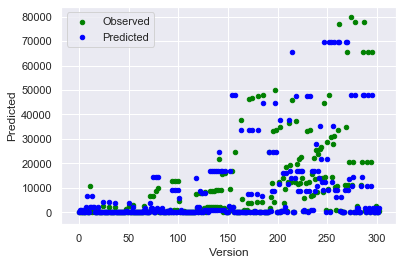

In [21]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [22]:
# Let's create multiple regression
X = df[[c.NT, c.NO, c.T_LINE_P, c.T_CONTRIBUTORS]]
# X = PCA_module_df[["PC1", "PC2"]]
Y = df[c.MODULE]

splits = 10
num_records = len(X)

pipeline = Pipeline(steps=[('scaler', transformer), ('predictor', regressor)])
model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
# model = regressor
model.fit(X, Y)
kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)
scores = cross_val_score(model, X, Y, cv=splits, scoring=utils.pred_25_scorer)
print(scores)

[0.52 0.81 0.29 1.   0.7  0.5  0.4  0.53 0.67 1.  ]


In [23]:
results = utils.create_percent_error_df(Y, predictions)
results['Version'] = np.arange(results.__len__())

print(utils.calculate_PRED(0.25, results, c.PERCENT_ERROR))
print(utils.calculate_PRED(0.50, results, c.PERCENT_ERROR))
print(utils.calculate_PRED(0.75, results, c.PERCENT_ERROR))
print(utils.calculate_PRED(1.00, results, c.PERCENT_ERROR))
results.head(100)

0.57
0.74
0.88
0.91


,Observed,Predicted,Difference,Percent_Error,Version
0,4.0,18.00,14.00,3.500000,0
1,16.0,82.33,66.33,4.150000,1
2,18.0,82.33,64.33,3.570000,2
3,0.0,0.00,0.00,0.000000,3
4,0.0,82.33,82.33,82.333333,4
...,...,...,...,...,...
95,7.0,4.38,2.62,0.370000,95
96,101.0,179.29,78.29,0.780000,96
97,909.0,640.50,268.50,0.300000,97
98,5.0,4.38,0.62,0.120000,98


In [24]:
feature_importances = pd.DataFrame(model.regressor_.named_steps['predictor'].feature_importances_, index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances
# feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

,importance
NO,0.695675
T_Contributors,0.205242
NT,0.072538
T_Line_P,0.026544


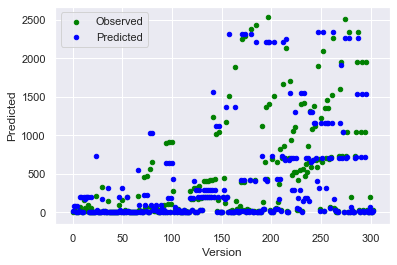

In [25]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [26]:
dot_data = StringIO()
plt.figure(figsize=(6,3))
export_graphviz(
    model.regressor_.named_steps['predictor'].estimators_[5], 
    # model, 
    out_file=dot_data, filled=True, rounded=True, proportion=False,
    special_characters=False, label="all", rotate=False,
    max_depth=10, 
    feature_names = [c.NT, c.NO, c.T_CONTRIBUTORS, c.T_LINE_P]
)    

AttributeError: 'DecisionTreeRegressor' object has no attribute 'estimators_'

In [27]:

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


^
Expected {'graph' | 'digraph'}  (at char 0), (line:1, col:1)


AttributeError: 'NoneType' object has no attribute 'create_png'